## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [1]:
import numpy as np
from collections import Counter

def gini(sequence):
    sequence = sequence.astype(dtype='int64')
    counts = np.bincount(sequence)
    probs = counts / sequence.size
    gini = 1
    for p in probs:
        if p > 0:
            gini -= p * p
    return gini

def compute_gini_gain(parent, left, right):
    ratio_left = len(left) / len(parent)
    ratio_right = 1 - ratio_left
    return gini(parent) - ratio_left * gini(left) - ratio_right * gini(right)

def entropy(sequence):
    sequence = sequence.astype(dtype='int64')
    counts = np.bincount(sequence)
    probs = counts / sequence.size
    entropy = 0
    for p in probs:
        if p > 0:
            entropy -= p * np.log2(p)
    return entropy

def compute_info_gain(parent, left, right):
    ratio_left = len(left) / len(parent)
    ratio_right = 1 - ratio_left
    return entropy(parent) - ratio_left * entropy(left) - ratio_right * entropy(right)

In [2]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [3]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [4]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [5]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
x_test_df = pd.read_csv('x_test.csv')
print(train_df.shape)
print(val_df.shape)
trainval_df  = pd.concat([train_df, val_df])
print(trainval_df.shape)

(1200, 21)
(300, 21)
(1500, 21)


In [6]:
x_train_data = train_df.drop("price_range", axis=1)
y_train_data = train_df["price_range"]

x_val_data = val_df.drop("price_range", axis=1).to_numpy()
y_val_data = val_df["price_range"].to_numpy(dtype='int64')

x_test_data = x_test_df.to_numpy()

print(type(x_train_data))
print(np.array(y_train_data).reshape(1, -1))

<class 'pandas.core.frame.DataFrame'>
[[1 0 0 ... 0 1 0]]


In [7]:
category = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
headers = x_train_data.columns.tolist()
column_names = {}
feature_cnt = [0 for i in range(len(headers))]

for i, header in enumerate(headers):
    column_names[i] = header
    

print(column_names)


{0: 'battery_power', 1: 'blue', 2: 'clock_speed', 3: 'dual_sim', 4: 'fc', 5: 'four_g', 6: 'int_memory', 7: 'm_dep', 8: 'mobile_wt', 9: 'n_cores', 10: 'pc', 11: 'px_height', 12: 'px_width', 13: 'ram', 14: 'sc_h', 15: 'sc_w', 16: 'talk_time', 17: 'three_g', 18: 'touch_screen', 19: 'wifi'}


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [8]:
x_train_data = x_train_data.to_numpy()
y_train_data = y_train_data.to_numpy(dtype='int64')

In [9]:
class Node():
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gini=None, info_gain=None, leaf_pred=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gini = gini
        self.info_gain = info_gain
        self.leaf_pred = leaf_pred
    

In [10]:
class DecisionTree:

    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        self.criterion = criterion
        self.max_depth = max_depth
        if max_features is not None:
            max_features = int(round(max_features))
        self.max_features = max_features
        self.root = None

    def _best_split(self, x_data, y_data):
        best_split = {}
        best_info_gain = -1
        best_gini_gain = -1
        # Random choose m features to be the best feature candidates
        if self.max_features is not None and self.max_features < x_data.shape[1]:
            selected_features = np.random.choice(a=x_data.shape[1], size=self.max_features, replace=False)
        else:
            selected_features = [i for i in range(x_data.shape[1])]
        # for feature in range(len(column_names)):
        for feature in selected_features:
            feature_values = x_data[:, feature]
            for threshold in np.unique(feature_values):

                df = np.concatenate((x_data, y_data.reshape(1, -1).T), axis=1)

                # category
                if column_names[feature] in category:
                    df_left = np.array([row for row in df if row[feature] == threshold])
                    df_right = np.array([row for row in df if row[feature] != threshold])
                # numerical
                else:
                    df_left = np.array([row for row in df if row[feature] <= threshold])
                    df_right = np.array([row for row in df if row[feature] > threshold])

                if len(df_left) > 0 and len(df_right) > 0:
                    y_data = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    if self.criterion == 'entropy':
                        info_gain = compute_info_gain(y_data, y_left, y_right)
                        if info_gain > best_info_gain:
                            best_split = {
                                'feature_index': feature,
                                'threshold': threshold,
                                'df_left': df_left,
                                'df_right': df_right,
                                'gain': info_gain
                            }
                            best_info_gain = info_gain
                            
                    elif self.criterion == 'gini':
                        gini_gain = compute_gini_gain(y_data, y_left, y_right)
                        if gini_gain > best_gini_gain:
                            best_split = {
                                'feature_index': feature,
                                'threshold': threshold,
                                'df_left': df_left,
                                'df_right': df_right,
                                'gini': gini_gain
                            }
                            best_gini_gain = gini_gain
        # Count feature importance
        if best_split != {}:
            feature_cnt[best_split['feature_index']] += 1

        return best_split
    
    def _build(self, x_data, y_data, cur_depth=0):
        # if self.criterion == 'gini' and entropy(y_data) == 0:
        #     print("gini, entropy = 0")

        # if self.criterion == 'entropy' and entropy(y_data) == 0:
        n_rows, n_cols = x_data.shape
        if (self.max_depth is None or cur_depth < self.max_depth) and entropy(y_data) != 0 and n_rows >= 2:
            best = self._best_split(x_data, y_data)
            if best == {}:
                return Node(leaf_pred=Counter(y_data).most_common(1)[0][0])
            left = self._build(
                x_data=best['df_left'][:, :-1], 
                y_data=best['df_left'][:, -1], 
                cur_depth=cur_depth + 1
            )
            right = self._build(
                x_data=best['df_right'][:, :-1], 
                y_data=best['df_right'][:, -1], 
                cur_depth=cur_depth + 1
            )
            if self.criterion == 'entropy':
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    info_gain=best['gain']
                )
            else:
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gini=best['gini']
                )

        return Node(
            leaf_pred=Counter(y_data).most_common(1)[0][0]
        )
    
    def fit(self, x_data, y_data):
        # print("x_data.shape = ", x_data.shape)
        self.root = self._build(x_data, y_data) # root is a root Node of a tree
        
    def _predict(self, x, tree):
        # Leaf node
        if tree.leaf_pred != None:
            return tree.leaf_pred
        # print("x.shape = ", x.shape)
        # print("tree.feature = ", tree.feature)
        feature_value = x[tree.feature]
        
        # Go to the left
        if column_names[tree.feature] in category:
            if feature_value == tree.threshold:
                return self._predict(x=x, tree=tree.data_left)
            else:
                return self._predict(x=x, tree=tree.data_right)
        else:
            if feature_value <= tree.threshold:
                return self._predict(x=x, tree=tree.data_left)
            
            # Go to the right
            if feature_value > tree.threshold:
                return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, x_data):
        y_pred_data = np.array([self._predict(x, self.root) for x in x_data])
        
        return y_pred_data

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [11]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train_data, y_train_data)
y_pred_data= clf_depth3.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy = ", accuracy)

feature_cnt = [0 for i in range(len(headers))]
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train_data, y_train_data)
y_pred_data= clf_depth10.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy = ", accuracy)
saved_feature_cnt = feature_cnt

Accuracy =  0.9166666666666666
Accuracy =  0.9366666666666666


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [12]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train_data, y_train_data)
y_pred_data= clf_gini.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy gini = ", accuracy)

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train_data, y_train_data)
y_pred_data= clf_entropy.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy entropy = ", accuracy)

Accuracy gini =  0.9166666666666666
Accuracy entropy =  0.93


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

[23, 1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 11, 5, 15, 0, 0, 1, 0, 0, 0]


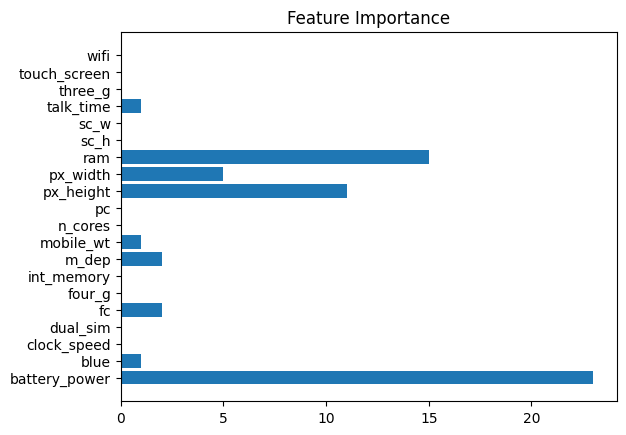

In [13]:
import matplotlib.pyplot as plt
plt.title("Feature Importance")
plt.barh(headers, saved_feature_cnt)
print(saved_feature_cnt)

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [14]:
class AdaBoost():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.trees = []
        
    def fit(self, x_data, y_data):
        num_data = x_data.shape[0]
        # initialize weight
        w = np.repeat(1/num_data, num_data)
        # initialize weighted data
        x_weighted_data, y_weighted_data = x_data, y_data
        # Start T iterations
        for i in range(self.n_estimators):
            # Generate tree as weak learner
            tree = DecisionTree(criterion='gini', max_depth=1)
            tree.fit(x_weighted_data, y_weighted_data)
            y_pred_data = tree.predict(x_data)  #####################################
            # Compute error, alpha as the weight of the weak learner
            error = w[y_pred_data != y_data].sum()
            alpha = 1/2 * np.log((1-error+1e-10) / (error+1e-10))
            # Compute normalized weight of each sample
            w = w * np.exp(-alpha * y_pred_data * y_data)
            w /= np.sum(w)
            # Select samples base on base on normalized weights
            choices = np.random.choice(len(x_weighted_data), len(x_weighted_data), p=w, replace=True)
            x_weighted_data = x_weighted_data[choices]
            y_weighted_data = y_weighted_data[choices]
            self.trees.append(tree)
            
    def predict(self, x_data):
        y_preds = []
        for tree in self.trees:
            y_preds.append(tree.predict(x_data))
        y_preds_swap = np.swapaxes(y_preds, axis1=0, axis2=1)
        y_pred_data = []
        for y_trees in y_preds_swap:
            y_pred_data.append(Counter(y_trees).most_common(1)[0][0])

        y_pred_data = np.array(y_pred_data)
        # accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
        return y_pred_data

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [15]:
adabooster10 = AdaBoost(n_estimators=10)
adabooster10.fit(x_train_data, y_train_data)
y_pred_data = adabooster10.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy 10 = ", accuracy)

adabooster100 = AdaBoost(n_estimators=100)
adabooster100.fit(x_train_data, y_train_data)
y_pred_data = adabooster100.predict(x_val_data)
accuracy100 = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy 100 = ", accuracy100)

Accuracy 10 =  0.8433333333333334
Accuracy 100 =  0.4866666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [16]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        if max_features is not None:
            max_features = int(round(max_features))
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = []


    def random_sample(self, x_data, y_data):
        num_row, _ = x_data.shape
        choices = np.random.choice(a=num_row, size=num_row, replace=True)
        x_data = x_data[choices]
        y_data = y_data[choices]

        return x_data, y_data

    def fit(self, x_data, y_data):
        
        for i in range(self.n_estimators):
            if self.boostrap:
                x_bs_data, y_bs_data = self.random_sample(x_data, y_data)
            tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            tree.fit(x_bs_data, y_bs_data)
            self.trees.append(tree)
            


    def predict(self, x_data):
            y_preds = [ tree.predict(x_data) for tree in self.trees ]
            y_preds_swap = np.swapaxes(a=y_preds, axis1=0, axis2=1)
            y_pred_data = []
            for y_trees in y_preds_swap:
                y_pred_data.append(Counter(y_trees).most_common(1)[0][0])

            y_pred_data = np.array(y_pred_data)
            return y_pred_data

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [17]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train_data.shape[1]))
clf_10tree.fit(x_train_data, y_train_data)
y_pred_data = clf_10tree.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy 10 = ", accuracy)

clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train_data.shape[1]))
clf_100tree.fit(x_train_data, y_train_data)
y_pred_data = clf_100tree.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy 100 = ", accuracy)



Accuracy 10 =  0.9366666666666666
Accuracy 100 =  0.9433333333333334


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [18]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train_data.shape[1]))
clf_random_features.fit(x_train_data, y_train_data)
y_pred_data = clf_random_features.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy random = ", accuracy)

clf_all_features = RandomForest(n_estimators=10, max_features=x_train_data.shape[1])
clf_all_features.fit(x_train_data, y_train_data)
y_pred_data = clf_all_features.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy all = ", accuracy)

# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_val_data, y_pred_data)


Accuracy random =  0.93
Accuracy all =  0.96


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

把train model的輸入改好，重新截圖報告要的內容，繳交檔案

In [19]:
class Ensemble():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None, feature_engineering=False):
        self.n_estimators = n_estimators
        if max_features is not None:
            max_features = int(round(max_features))
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.feature_engineering = feature_engineering
        self.trees = []


    def random_sample(self, x_data, y_data):
        num_row, _ = x_data.shape
        choices = np.random.choice(a=num_row, size=num_row, replace=True)
        x_data = x_data[choices]
        y_data = y_data[choices]

        return x_data, y_data

    def fit(self, x_data, y_data):
        
        for i in range(self.n_estimators):
            if self.boostrap:
                x_bs_data, y_bs_data = self.random_sample(x_data, y_data)
            tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            tree.fit(x_bs_data, y_bs_data)
            self.trees.append(tree)
            


    def predict(self, x_data):
        if self.feature_engineering:
            width_times_height = np.expand_dims(x_data[:,11] * x_data[:,12], axis=1)
            battery_times_RAM = np.expand_dims(x_data[:,0] * x_data[:,13], axis=1)
            x_data = np.concatenate((x_data, width_times_height, battery_times_RAM), axis=1)
        
        y_preds = [ tree.predict(x_data) for tree in self.trees ]
        y_preds_swap = np.swapaxes(a=y_preds, axis1=0, axis2=1)
        y_pred_data = []
        for y_trees in y_preds_swap:
            y_pred_data.append(Counter(y_trees).most_common(1)[0][0])

        y_pred_data = np.array(y_pred_data)
        return y_pred_data

In [28]:

def train_your_model(trainval_df): # WRONG
    x_train_data = trainval_df.drop("price_range", axis=1).to_numpy()
    y_train_data = trainval_df["price_range"].to_numpy()
    
    
    my_model = Ensemble(n_estimators=150, criterion='gini', max_depth=None, max_features=x_train_data.shape[1], feature_engineering=True) #np.sqrt(x_train_new.shape[1])) # x_train_new.shape[1] + 
    my_model.fit(x_train_data, y_train_data)
    
    return my_model

In [29]:
my_model = train_your_model(trainval_df)


In [30]:
y_pred_data = my_model.predict(x_train_data)
accuracy = (y_train_data == y_pred_data).sum() / len(y_train_data)
print("Accuracy random = ", accuracy)

Accuracy random =  1.0


In [41]:
import pickle
my_model7 = pickle.load(open("model.pkl", "rb"))

In [42]:
y_pred_data = my_model7.predict(x_val_data)
accuracy = (y_val_data == y_pred_data).sum() / len(y_val_data)
print("Accuracy random = ", accuracy)

Accuracy random =  1.0


In [35]:
y_pred = my_model.predict(x_test_data)

In [36]:
import pickle
pickle.dump(my_model, open('model.pkl', 'wb'))
np.save("y_pred.npy", y_pred)

In [37]:
loaded = np.load("y_pred.npy")
print(loaded)

[0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.

In [34]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [27]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [ ]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
